# Building a WaveNet

## Starter Code

### Imports

In [ ]:
import numpy
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

### Read words

In [ ]:
words = open('../data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


### Build vocabulary of characters and mapping to/from integers

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Shuffle words

In [ ]:
import random
random.seed(42)
random.shuffle(words)

### Build the dataset

In [ ]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


### Neural Network

In [ ]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [ ]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [ ]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [ ]:
torch.manual_seed(42);

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# parameter init
with torch.no_grad():
    layers[-1].weight * 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


### Training

In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

      0/ 200000:  3.4915
  10000/ 200000:  2.2179
  20000/ 200000:  2.3681
  30000/ 200000:  2.1342
  40000/ 200000:  2.4067
  50000/ 200000:  2.2406
  60000/ 200000:  1.9608
  70000/ 200000:  1.9236
  80000/ 200000:  2.6588
  90000/ 200000:  2.0502
 100000/ 200000:  2.2596
 110000/ 200000:  1.6270
 120000/ 200000:  2.1705
 130000/ 200000:  2.2806
 140000/ 200000:  2.1980
 150000/ 200000:  1.8434
 160000/ 200000:  1.8251
 170000/ 200000:  2.3077
 180000/ 200000:  2.0817
 190000/ 200000:  2.1585


[<matplotlib.lines.Line2D>]

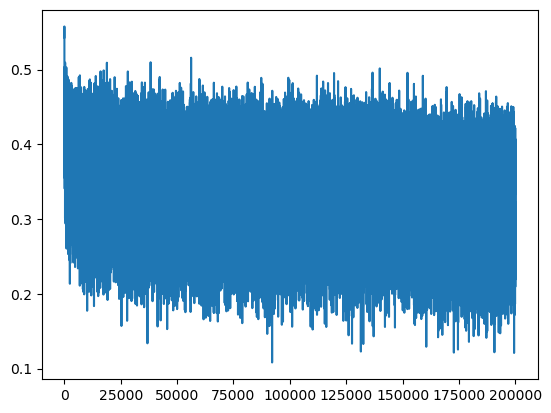

In [ ]:
plt.plot(lossi)

### Eval Mode

In [ ]:
# put layers into eval mode (needed for batchnorm especially)

for layer in layers:
    layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {  
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

NameError: name 'C' is not defined

### Sample from model

In [ ]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0: break
        
    print(''.join(itos[i] for i in out))

ivon.
fanili.
thoommestenell.
mattevyn.
alana.
joleshaun.
siah.
prus.
carleen.
jah.
jorrena.
joriah.
jas.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.
esteffead.


## Fix the lr plot

In [ ]:
lossi[:10]

[0.5430157780647278,
 0.5576249957084656,
 0.523175835609436,
 0.5327444672584534,
 0.5206513404846191,
 0.5284044742584229,
 0.5306796431541443,
 0.5056970119476318,
 0.5213009119033813,
 0.5147265195846558]

In [ ]:
torch.arange(10).view(2, 5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [ ]:
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([200, 1000])

In [ ]:
torch.tensor(lossi).view(-1, 1000).mean(1).shape

torch.Size([200])

[<matplotlib.lines.Line2D>]

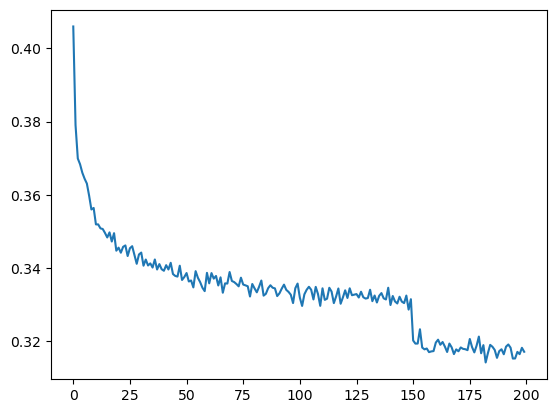

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

## Pytorchifying the code
> layers, containers, torch.nn, fun bugs

#### Layers
> Introducing new layers: embedding, flatten

In [ ]:
class Embedding: 
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

In [ ]:
class Flatten:
    
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    x = Xb
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

      0/ 200000:  3.6104
  10000/ 200000:  2.1986
  20000/ 200000:  2.3563
  30000/ 200000:  2.2846
  40000/ 200000:  2.3796
  50000/ 200000:  2.2467
  60000/ 200000:  2.2208
  70000/ 200000:  2.3856
  80000/ 200000:  1.7651
  90000/ 200000:  2.1291
 100000/ 200000:  2.0727
 110000/ 200000:  2.3707
 120000/ 200000:  1.8593
 130000/ 200000:  2.2348
 140000/ 200000:  1.7190
 150000/ 200000:  2.3271
 160000/ 200000:  1.9129
 170000/ 200000:  2.0262
 180000/ 200000:  1.7435
 190000/ 200000:  2.2444


#### Containers

In [ ]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    layers[-1].weight * 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    logits = model(Xb)
    
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

      0/ 200000:  3.6506
  10000/ 200000:  2.3977
  20000/ 200000:  1.8598
  30000/ 200000:  2.1111
  40000/ 200000:  2.3361
  50000/ 200000:  2.1747
  60000/ 200000:  2.1322
  70000/ 200000:  2.3737
  80000/ 200000:  2.1701
  90000/ 200000:  2.1263
 100000/ 200000:  1.7871
 110000/ 200000:  2.3637
 120000/ 200000:  2.1640
 130000/ 200000:  2.1788
 140000/ 200000:  2.4404
 150000/ 200000:  2.1481
 160000/ 200000:  2.0980
 170000/ 200000:  2.0363
 180000/ 200000:  2.1364
 190000/ 200000:  1.8888


#### eval mode

In [ ]:
# put layers into eval mode (needed for batchnorm especially)

for layer in model.layers:
    layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {  
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.765791416168213
val 1.9921294450759888


#### Sample from model

In [ ]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0: break
        
    print(''.join(itos[i] for i in out))

nayah.
kent.
rohyn.
aaissalyn.
axminaiyah.
tayyah.
dum.
brena.
hoselia.
kehanikki.
ormonadit.
luchelyn.
lin.
jannal.
noes.
sude.
raylen.
anvika.
alea.
wylin.


## Increase the context size

In [ ]:
block_size = 8

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
    layers[-1].weight * 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


#### training mode

In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    #forward pass
    logits = model(Xb)
    
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())

      0/ 200000:  3.7162
  10000/ 200000:  1.8141
  20000/ 200000:  2.0207
  30000/ 200000:  2.1630
  40000/ 200000:  2.4232
  50000/ 200000:  2.3131
  60000/ 200000:  1.9144
  70000/ 200000:  1.9182
  80000/ 200000:  2.4822
  90000/ 200000:  2.1356
 100000/ 200000:  2.0794
 110000/ 200000:  2.1322
 120000/ 200000:  1.8838
 130000/ 200000:  2.3476
 140000/ 200000:  2.0343
 150000/ 200000:  2.0312
 160000/ 200000:  2.3358
 170000/ 200000:  2.0393
 180000/ 200000:  2.1933
 190000/ 200000:  1.9221


#### eval mode

In [ ]:
# put layers into eval mode (needed for batchnorm especially)

for layer in model.layers:
    layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {  
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9201935529708862
val 2.0279388427734375


### Performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027

In [ ]:
# sample from model

for _ in range(20):
    
    out = []
    context = [0] * block_size
    
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0: break
    
    print(''.join(itos[i] for i in out))

henyx.
terna.
nyaad.
maganta.
jalori.
delci.
dysenni.
kalven.
allington.
teb.
kingstonaa.
leonnsta.
paisle.
anny.
shanidi.
azrislaca.
brandan.
jiriana.
nathawa.
ella.


## Implementing Wavenet

In [ ]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # lets look at batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1, 19,  8, 22]])

In [ ]:
ix

tensor([ 71354,  75603,   1768, 142786])

In [ ]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [ ]:
model.layers[1].out.shape

torch.Size([4, 80])

In [ ]:
model.layers[2].out.shape

torch.Size([4, 200])

In [ ]:
(torch.randn(4, 5, 6, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 6, 200])

In [ ]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [ ]:
e = torch.randn(4, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10d vectors are concatenated
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)

In [ ]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [ ]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1: 
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

In [ ]:
block_size

8

In [ ]:
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model  = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters: p.requires_grad = True

22097


In [ ]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 12,  1]])

In [ ]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [ ]:
block_size = 2

In [ ]:
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model  = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size), Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(block_size), Linear(n_hidden * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(block_size), Linear(n_hidden * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters: p.requires_grad = True

170897


In [ ]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1,  2,  8,  9],
        [ 0,  0,  0,  0,  0, 18,  1,  9],
        [ 0,  0,  0,  0,  0,  0,  7,  1]])

In [ ]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


## Training Wavenet: First Pass

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP 
# --> want to have the same parameters when the block size was 8

block_size = 2

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters: p.requires_grad = True

22397


In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters: 
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.6852
  10000/ 200000: 2.3648
  20000/ 200000: 2.1416
  30000/ 200000: 1.9978
  40000/ 200000: 2.2832
  50000/ 200000: 1.9900
  60000/ 200000: 2.0611
  70000/ 200000: 1.8055
  80000/ 200000: 2.6343
  90000/ 200000: 2.1440
 100000/ 200000: 2.0204
 110000/ 200000: 1.8402
 120000/ 200000: 1.5136
 130000/ 200000: 1.8751
 140000/ 200000: 2.1031
 150000/ 200000: 2.0538
 160000/ 200000: 2.0164
 170000/ 200000: 2.2596
 180000/ 200000: 1.9372
 190000/ 200000: 1.6855


In [ ]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


[<matplotlib.lines.Line2D>]

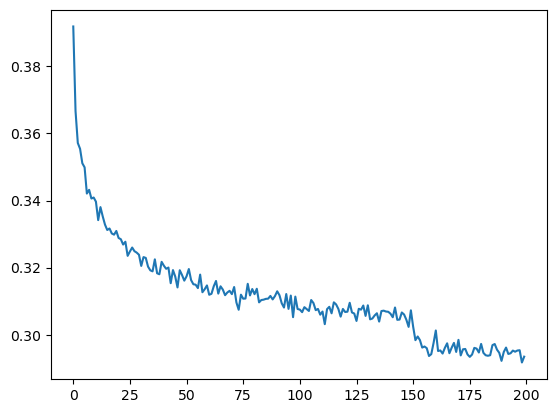

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers: layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.9430139064788818
val 2.027573585510254


## Fixing BatchNorm1D bug

In [ ]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2: dim = 0
            elif x.ndim == 3: dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP 
# --> want to have the same parameters when the block size was 8

# block_size = 2

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
# with torch.no_grad():
#     layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters: p.requires_grad = True

22397


In [ ]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  8,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 11,  1, 13,  2, 18],
        [ 0, 25,  1, 26, 13,  9, 14,  5]])

In [ ]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [ ]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters: 
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.4804
  10000/ 200000: 1.9962
  20000/ 200000: 2.0834
  30000/ 200000: 2.0940
  40000/ 200000: 2.6074
  50000/ 200000: 1.9911
  60000/ 200000: 1.6505
  70000/ 200000: 2.0625
  80000/ 200000: 2.0239
  90000/ 200000: 1.9839
 100000/ 200000: 1.8198
 110000/ 200000: 1.9920
 120000/ 200000: 1.8590
 130000/ 200000: 2.0162
 140000/ 200000: 1.9531
 150000/ 200000: 1.9374
 160000/ 200000: 1.7478
 170000/ 200000: 1.7850
 180000/ 200000: 1.9224
 190000/ 200000: 1.7220


[<matplotlib.lines.Line2D>]

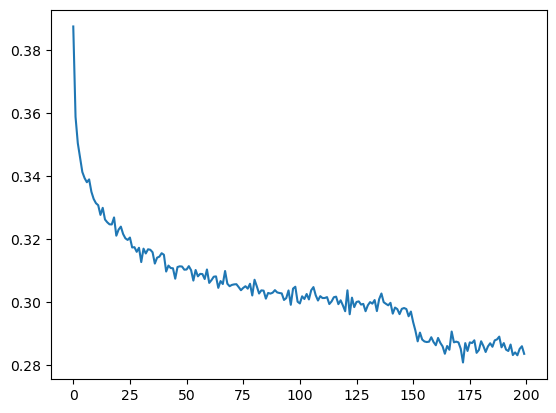

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
for layer in model.layers: layer.training = False

In [ ]:
split_loss('train')

train 1.9116132259368896


In [ ]:
split_loss('val')

val 2.023597240447998


In [ ]:
split_loss('test')

test 2.013340711593628


## Scaling up Wavenet

In [ ]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP 
# --> want to have the same parameters when the block size was 8


model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters: p.requires_grad = True

76579


In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
    for p in parameters: 
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2997
  10000/ 200000: 1.8203
  20000/ 200000: 1.8036
  30000/ 200000: 2.1780
  40000/ 200000: 2.1453
  50000/ 200000: 1.8008
  60000/ 200000: 1.6666
  70000/ 200000: 2.3526
  80000/ 200000: 1.4201
  90000/ 200000: 1.7949
 100000/ 200000: 1.5605
 110000/ 200000: 1.7919
 120000/ 200000: 1.6035
 130000/ 200000: 1.9319
 140000/ 200000: 1.8383
 150000/ 200000: 1.6744
 160000/ 200000: 1.5064
 170000/ 200000: 1.3609
 180000/ 200000: 1.8823
 190000/ 200000: 2.1009


In [ ]:
for layer in model.layers: layer.training = False

In [ ]:
split_loss('train')
split_loss('val')

train 1.765791416168213
val 1.9921294450759888


In [ ]:
len(Xdev)

22655